# Tutorial 0: Basic examples

In [1]:
import warnings
import sys

warnings.filterwarnings("ignore")

from sklearn.datasets import load_diabetes
from synthcity.plugins import Plugins
import synthcity.logger as log

log.add(sink=sys.stderr, level="INFO")

X, y = load_diabetes(return_X_y=True, as_frame=True)
X["target"] = y

X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


## List the available generative models

In [2]:
from synthcity.plugins import Plugins

Plugins().list()

['pategan',
 'nflow',
 'privbayes',
 'copulagan',
 'rtvae',
 'bayesian_network',
 'tvae',
 'gaussian_copula',
 'ctgan',
 'adsgan']

## Load and train a generative model

In [3]:
from synthcity.plugins import Plugins

syn_model = Plugins().get("marginal_distributions")

syn_model.fit(X)

## Generate new data using the model

In [4]:
syn_model.generate(count=10)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.063888,0.050680,0.029187,-0.075373,-0.004767,-0.085936,-0.079495,0.148953,-0.107115,0.037608,278.145557
1,0.104581,0.050680,0.006902,0.119228,-0.078558,-0.076746,-0.000315,0.116231,-0.037560,-0.036009,172.202429
2,0.008034,-0.044642,0.027258,-0.054593,-0.001314,0.016646,-0.069414,-0.015694,0.001355,-0.068474,323.047521
3,-0.006090,-0.044642,0.033702,0.129296,0.123640,0.044409,0.026726,-0.018040,0.046719,-0.118088,190.827277
4,-0.085702,-0.044642,0.012565,-0.054985,0.107216,-0.013855,-0.062196,0.182661,-0.090771,0.047330,29.299552
5,-0.051012,-0.044642,-0.011272,-0.033998,-0.092046,-0.054942,-0.084932,0.048130,-0.014335,-0.004425,166.440231
6,-0.024039,-0.044642,-0.039819,0.093495,0.120343,0.017731,0.112411,0.172806,-0.011318,0.008845,120.964736
7,0.098081,-0.044642,0.007853,-0.021675,0.053273,0.157424,0.095282,-0.008454,-0.112581,0.075091,72.938502
8,0.060790,-0.044642,-0.001418,-0.000125,-0.061105,-0.112728,0.066297,0.032482,0.067131,0.044997,119.954125
9,0.046218,-0.044642,0.036296,0.007909,-0.021272,0.026502,0.081903,0.072031,0.019968,-0.050436,203.086617


## Generate new data under some constraints

In [5]:
# Constraint: target <= 100
from synthcity.plugins.core.constraints import Constraints

constraints = Constraints(rules=[("target", "<=", 100)])

generated = syn_model.generate(count=10, constraints=constraints)

assert (generated["target"] <= 100).any()

generated

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.058732,-0.044642,-0.075270,0.071808,0.118527,0.092735,0.071802,0.040640,0.123222,-0.014233,77.355038
1,0.008991,-0.044642,0.164583,-0.010061,0.044186,0.177772,-0.044512,-0.062240,-0.111845,-0.005521,57.556766
2,0.025677,-0.044642,0.011202,0.083535,-0.022806,0.160613,0.118425,-0.015277,0.078213,0.001068,43.878183
3,-0.105608,0.050680,0.150917,-0.006689,0.087896,0.085178,-0.019265,0.129591,-0.105543,0.101912,73.214256
4,-0.103713,-0.044642,-0.082494,-0.087646,-0.121718,0.097541,-0.002172,-0.069021,0.025404,-0.026258,45.436268
5,0.091717,-0.044642,0.078947,-0.060954,0.006476,0.126630,0.039358,-0.001578,0.012321,0.121157,88.797330
6,-0.044322,-0.044642,0.122321,0.118655,-0.022517,-0.055936,0.084806,0.022359,-0.108610,0.104886,62.588230
7,0.097882,-0.044642,0.034642,-0.043862,0.001642,0.055876,-0.042413,0.167533,0.092617,-0.017234,88.743399
8,-0.102130,-0.044642,-0.077530,0.001660,0.073670,0.126950,0.042905,0.148248,0.086806,-0.003428,46.946941
9,-0.000217,0.050680,0.149557,0.025657,0.011361,0.105222,0.094771,-0.000782,-0.063865,0.090523,87.411884


In [6]:
# Constraint: target > 150

from synthcity.plugins.core.constraints import Constraints

constraints = Constraints(rules=[("target", ">", 150)])

generated = syn_model.generate(count=10, constraints=constraints)

assert (generated["target"] > 150).any()

generated

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.023876,-0.044642,-0.043442,-0.011168,-0.017087,-0.089107,-0.027488,0.106846,0.032410,0.048486,328.748968
1,0.076758,-0.044642,-0.048959,0.081874,0.121738,0.155680,0.075142,-0.035110,0.096292,-0.109361,235.546707
2,-0.038919,-0.044642,-0.003079,-0.036842,0.005017,-0.025431,-0.010216,0.008910,-0.028001,0.029799,241.595267
3,0.074146,0.050680,0.039689,-0.027417,-0.093244,-0.086231,-0.001167,-0.007344,-0.008736,-0.040980,291.198559
4,0.049798,-0.044642,0.095801,-0.103120,-0.107948,0.032309,-0.070147,0.062296,0.025335,-0.003196,238.046754
5,0.100747,0.050680,-0.046308,-0.007529,0.044913,0.135758,-0.047046,-0.024790,-0.077992,0.110375,306.782965
6,-0.097584,-0.044642,-0.045669,-0.106667,-0.075851,0.114803,0.077105,-0.055492,0.075105,0.022007,241.560377
7,-0.034578,0.050680,0.149503,-0.069191,-0.072765,0.102580,0.083662,0.114394,-0.023243,-0.052183,326.920233
8,-0.060318,0.050680,0.035762,0.034000,-0.074576,-0.078228,0.015281,-0.062082,0.115674,0.024218,305.215920
9,-0.010538,-0.044642,0.043051,-0.063515,-0.114581,0.185694,0.162192,0.012490,-0.046791,0.088835,172.344192


## Plot real-synthetic distributions

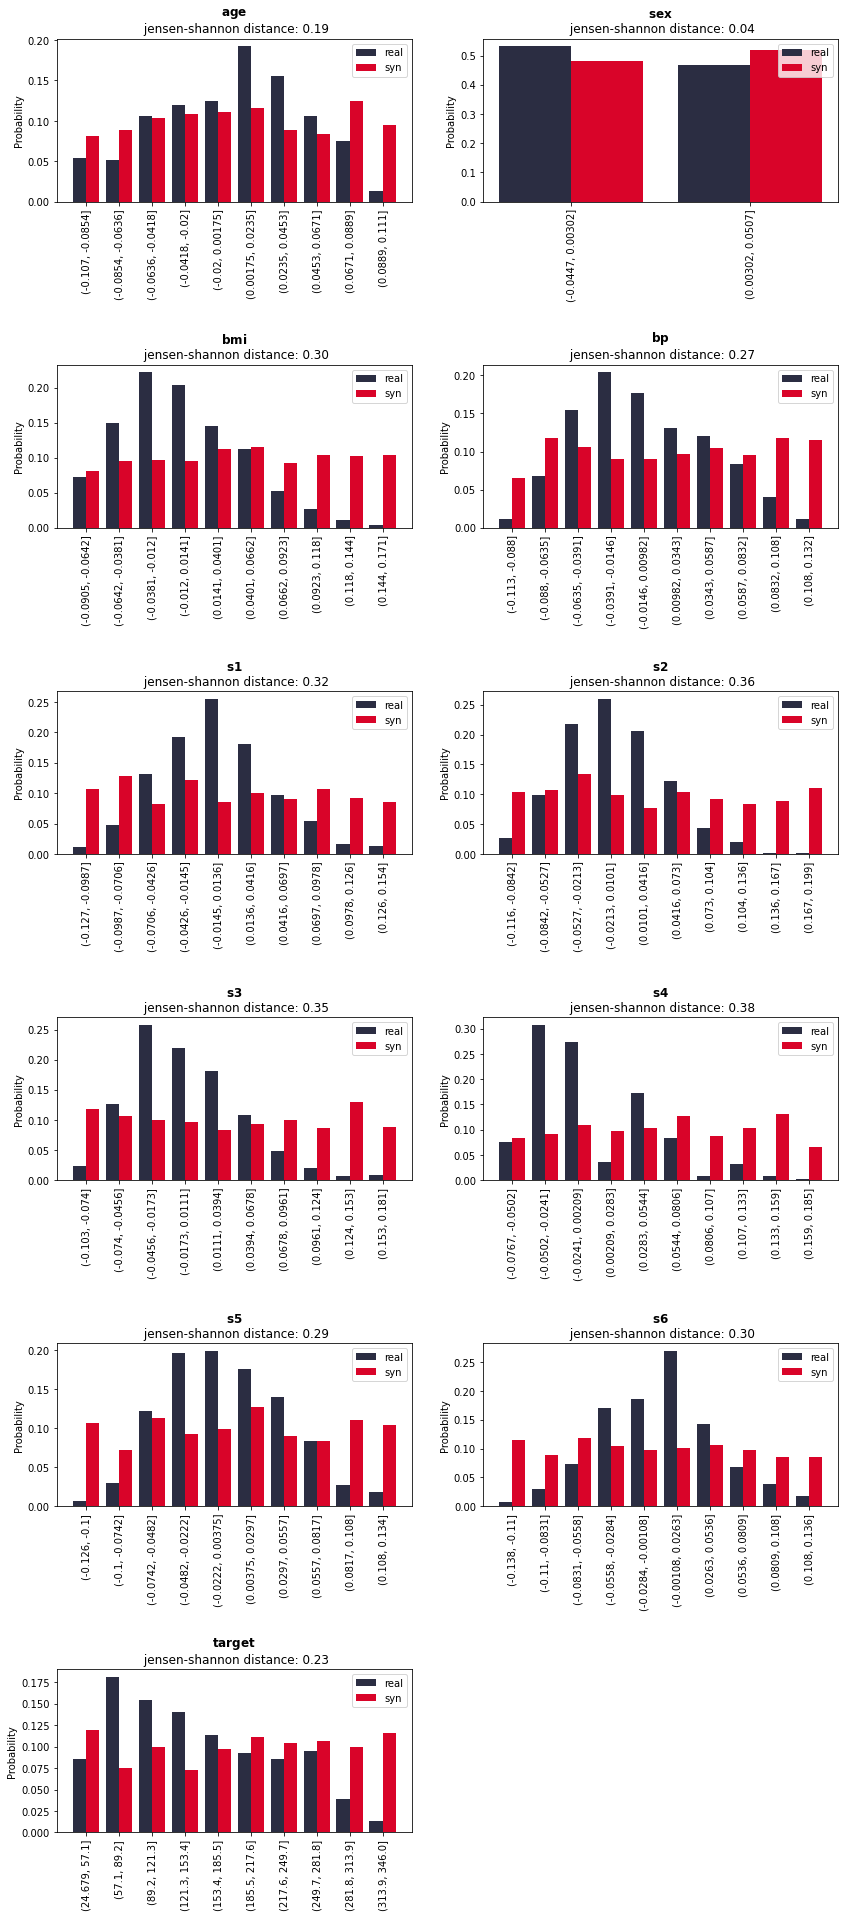

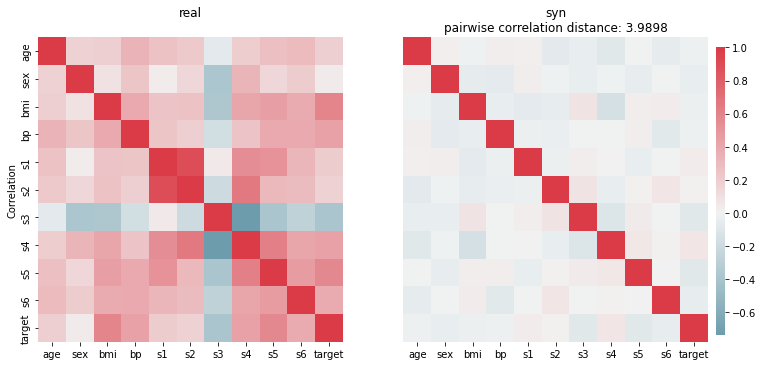

In [7]:
import matplotlib.pyplot as plt

syn_model.plot(plt, X)

plt.show()

## Benchmark the quality of plugins

In [8]:
from synthcity.benchmark import Benchmarks

constraints = Constraints(rules=[("target", "ge", 150)])

score = Benchmarks.evaluate(
    ["marginal_distributions", "dummy_sampler"],
    X,
    sensitive_columns=["sex"],
    synthetic_size=1000,
    synthetic_constraints=constraints,
    repeats=5,
)

[2022-05-23T11:35:05.254444+0300][45063][INFO] Benchmarking plugin : marginal_distributions
[2022-05-23T11:35:05.258303+0300][45063][INFO]  Experiment repeat: 0 task type: classification Train df hash = 3983295630968204409
[2022-05-23T11:35:30.589681+0300][45063][INFO]  Experiment repeat: 1 task type: classification Train df hash = 3703976102254353607
[2022-05-23T11:35:53.216701+0300][45063][INFO]  Experiment repeat: 2 task type: classification Train df hash = 6067181599866530555
[2022-05-23T11:36:15.855711+0300][45063][INFO]  Experiment repeat: 3 task type: classification Train df hash = 7865676556638030131
[2022-05-23T11:36:38.603446+0300][45063][INFO]  Experiment repeat: 4 task type: classification Train df hash = 2401327467211717343
[2022-05-23T11:37:01.183660+0300][45063][INFO] Benchmarking plugin : dummy_sampler
[2022-05-23T11:37:01.186531+0300][45063][INFO]  Experiment repeat: 0 task type: classification Train df hash = 3983295630968204409
[2022-05-23T11:37:23.933642+0300][45063

In [9]:
Benchmarks.print(score)


Comparatives


,marginal_distributions,dummy_sampler
sanity.data_mismatch.score,0.0,0.0
sanity.common_rows_proportion.score,0.0,0.403399
sanity.nearest_syn_neighbor_distance.mean,0.258735,0.257644
sanity.close_values_probability.score,0.559207,0.559207
sanity.distant_values_probability.score,0.052125,0.052125
stats.jensenshannon_dist.marginal,0.301839,0.168944
stats.chi_squared_test.marginal,0.905908,0.414693
stats.feature_corr.joint,3.9667,1.187756
stats.inv_kl_divergence.marginal,0.707401,0.74875
stats.ks_test.marginal,0.727273,0.810919


In [10]:
import pandas as pd
import numpy as np

means = []
for plugin in score:
    data = score[plugin]["mean"]
    directions = score[plugin]["direction"].to_dict()
    means.append(data)

out = pd.concat(means, axis=1)
out.set_axis(score.keys(), axis=1, inplace=True)

bad_highlight = "background-color: lightcoral;"
ok_highlight = "background-color: green;"
default = ""


def highlights(row):
    metric = row.name
    if directions[metric] == "minimize":
        best_val = np.min(row.values)
        worst_val = np.max(row)
    else:
        best_val = np.max(row.values)
        worst_val = np.min(row)

    styles = []
    for val in row.values:
        if val == best_val:
            styles.append(ok_highlight)
        elif val == worst_val:
            styles.append(bad_highlight)
        else:
            styles.append(default)

    return styles


out.style.apply(highlights, axis=1)

,marginal_distributions,dummy_sampler
sanity.data_mismatch.score,0.000000,0.000000
sanity.common_rows_proportion.score,0.000000,0.403399
sanity.nearest_syn_neighbor_distance.mean,0.258735,0.257644
sanity.close_values_probability.score,0.559207,0.559207
sanity.distant_values_probability.score,0.052125,0.052125
stats.jensenshannon_dist.marginal,0.301839,0.168944
stats.chi_squared_test.marginal,0.905908,0.414693
stats.feature_corr.joint,3.966700,1.187756
stats.inv_kl_divergence.marginal,0.707401,0.748750
stats.ks_test.marginal,0.727273,0.810919


# 